In [401]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import sklearn
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
import statsmodels.formula.api as smf

# Display preferences.
%matplotlib inline

pd.options.display.float_format = '{:.3f}'.format
pd.options.display.max_rows = 999

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

# Non-DataScience/ML packages
import chardet
import re
import string

In [402]:
state = 'new_york'
state = 'california'
path="../../../../Datafiles/"
file = 'table_8_offenses_known_to_law_enforcement_{}_by_city_2013.xls'.format(state)
print("We are working with data from the wonderful state of {}".format(state))
df = pd.read_excel(path + file, header=4)
print("there are {} entries in the data frame".format(len(df)))

We are working with data from the wonderful state of california
there are 464 entries in the data frame


In [403]:
# Let's clean up the column names
colnames = df.columns
newcolnameslist = []

for colname in colnames:
    newcolname=colname.replace('\n','').replace(' ','').capitalize() # strip out newlines, spaces, and captitalize
    newcolname=re.sub(r'\([^)]*\)', '', newcolname)                  # remove parenthesized stuff
    newcolnameslist.append(newcolname)                               # put all the column names into a list 

df.columns = newcolnameslist
print(newcolnameslist)

['City', 'Population', 'Violentcrime', 'Murderandnonnegligentmanslaughter', 'Rape1', 'Rape2', 'Robbery', 'Aggravatedassault', 'Propertycrime', 'Burglary', 'Larceny-theft', 'Motorvehicletheft', 'Arson']


In [404]:
df[df['City'].str.contains('figures shown')]
df[df['City'].str.contains('publish')]

df = df[(df['City'].str.contains('figures shown') == False)] # We don't want any documentation rows
df = df[(df['City'].str.contains('publish') == False)]       # We don't want any other documentation rows

In [405]:
df['PopulationSquared'] = df.Population.pow(2)

df['Robbery'] = np.where(df['Robbery']>=1, 1, 0.0)
df = df.rename(columns={'Arson3': 'Arson', 'Rape2': 'Rape', 'Aggravatedassault': 'AggravatedAssault',
                        'Violentcrime':'ViolentCrime','Propertycrime': 'PropertyCrime', 
                        'Larceny-theft':'LarcenyTheft','Motorvehicletheft':'MotorVehicleTheft'})
# df.Arson = df.Arson.astype(int) # Let's make it an int
df['Murder'] = np.where(df['Murderandnonnegligentmanslaughter']>=1, 1, 0.0)
df.Arson.fillna(0, inplace=True) # Let's clean up Arson3

In [406]:
df.head(5)
# df.describe()

,City,Population,ViolentCrime,Murderandnonnegligentmanslaughter,Rape1,Rape,Robbery,AggravatedAssault,PropertyCrime,Burglary,LarcenyTheft,MotorVehicleTheft,Arson,PopulationSquared,Murder
0,Adelanto,31165.000,198.000,2.000,nan,15.000,1.000,129.000,886.000,381.000,372.000,133.000,17.000,971257225.000,1.000
1,Agoura Hills,20762.000,19.000,0.000,nan,2.000,1.000,7.000,306.000,109.000,185.000,12.000,7.000,431060644.000,0.000
2,Alameda,76206.000,158.000,0.000,nan,10.000,1.000,63.000,1902.000,287.000,1285.000,330.000,17.000,5807354436.000,0.000
3,Albany,19104.000,29.000,0.000,nan,1.000,1.000,4.000,557.000,94.000,388.000,75.000,7.000,364962816.000,0.000
4,Alhambra,84710.000,163.000,1.000,nan,9.000,1.000,72.000,1774.000,344.000,1196.000,234.000,7.000,7175784100.000,1.000


In [407]:
num_columns = ['Population', 'ViolentCrime', 'Rape', 'AggravatedAssault', 'PropertyCrime', 'Burglary','LarcenyTheft',
                                               'MotorVehicleTheft', 'Arson']

In [408]:
# Let's scale the crime by population of the city size.
factor=100000
df_pop=df
df_pop['ViolentCrime_pop'] = df['ViolentCrime']/df['Population']*factor
df_pop['Rape_pop'] = df['Rape']/df['Population']*factor
df_pop['AggravatedAssault_pop'] = df['AggravatedAssault']/df['Population']*factor
df_pop['PropertyCrime_pop'] = df['PropertyCrime']/df['Population']*factor
df_pop['Burglary_pop'] = df['Burglary']/df['Population']*factor
df_pop['LarcenyTheft_pop'] = df['LarcenyTheft']/df['Population']*factor
df_pop['MotorVehicleTheft_pop'] = df['MotorVehicleTheft']/df['Population']*factor
df_pop['Arson_pop'] = df['Arson']/df['Population']*factor

In [409]:
df_pop.describe()

,Population,ViolentCrime,Murderandnonnegligentmanslaughter,Rape1,Rape,Robbery,AggravatedAssault,PropertyCrime,Burglary,LarcenyTheft,...,PopulationSquared,Murder,ViolentCrime_pop,Rape_pop,AggravatedAssault_pop,PropertyCrime_pop,Burglary_pop,LarcenyTheft_pop,MotorVehicleTheft_pop,Arson_pop
count,462.000,462.000,462.000,0.000,462.000,462.000,462.000,462.000,462.000,462.000,...,462.000,462.000,462.000,462.000,462.000,462.000,462.000,462.000,462.000,462.000
mean,68606.926,269.693,3.030,nan,13.126,0.924,149.565,1883.084,412.158,1168.405,...,47542913641.325,0.457,426.111,25.189,266.538,4287.656,817.938,2712.285,757.432,18.742
std,207192.961,1004.376,13.711,nan,43.274,0.265,476.014,5427.651,1026.459,3512.717,...,706890645729.114,0.499,1392.739,89.451,723.213,25196.128,2553.531,16499.895,6352.288,33.305
min,115.000,0.000,0.000,nan,0.000,0.000,0.000,3.000,0.000,1.000,...,13225.000,0.000,0.000,0.000,0.000,263.273,0.000,52.493,0.000,0.000
25%,12198.000,27.000,0.000,nan,2.000,1.000,17.000,281.000,75.500,161.250,...,148793904.000,0.000,141.578,7.555,88.864,1693.827,400.697,1017.787,135.700,2.955
50%,32045.500,77.500,0.000,nan,5.000,1.000,51.000,721.000,175.000,444.500,...,1027281912.500,0.000,275.769,15.356,161.881,2325.105,545.540,1418.526,248.314,10.715
75%,71918.000,200.750,2.000,nan,12.000,1.000,120.000,1879.250,401.250,1194.500,...,5172390751.000,1.000,432.106,27.162,286.156,3164.753,814.469,1907.796,461.527,19.635
max,3878725.000,16524.000,251.000,nan,764.000,1.000,7624.000,85844.000,15728.000,55734.000,...,15044507625625.000,1.000,22869.955,1793.722,13004.484,466816.143,49327.354,316143.498,101345.291,448.430


In [410]:
df_pop[['City','Population','Rape_pop','ViolentCrime_pop','AggravatedAssault_pop','PropertyCrime_pop','Burglary_pop','LarcenyTheft_pop','MotorVehicleTheft_pop','Arson_pop']];

In [411]:
df_pop.head(5)

,City,Population,ViolentCrime,Murderandnonnegligentmanslaughter,Rape1,Rape,Robbery,AggravatedAssault,PropertyCrime,Burglary,...,PopulationSquared,Murder,ViolentCrime_pop,Rape_pop,AggravatedAssault_pop,PropertyCrime_pop,Burglary_pop,LarcenyTheft_pop,MotorVehicleTheft_pop,Arson_pop
0,Adelanto,31165.000,198.000,2.000,nan,15.000,1.000,129.000,886.000,381.000,...,971257225.000,1.000,635.328,48.131,413.926,2842.933,1222.525,1193.647,426.761,54.548
1,Agoura Hills,20762.000,19.000,0.000,nan,2.000,1.000,7.000,306.000,109.000,...,431060644.000,0.000,91.513,9.633,33.715,1473.846,524.998,891.051,57.798,33.715
2,Alameda,76206.000,158.000,0.000,nan,10.000,1.000,63.000,1902.000,287.000,...,5807354436.000,0.000,207.333,13.122,82.671,2495.866,376.611,1686.219,433.037,22.308
3,Albany,19104.000,29.000,0.000,nan,1.000,1.000,4.000,557.000,94.000,...,364962816.000,0.000,151.801,5.235,20.938,2915.620,492.044,2030.988,392.588,36.642
4,Alhambra,84710.000,163.000,1.000,nan,9.000,1.000,72.000,1774.000,344.000,...,7175784100.000,1.000,192.421,10.624,84.996,2094.204,406.091,1411.876,276.237,8.263


In [429]:
print("Scores by population data frame, df_pop")
# Acquire, load, and preview the data.
regr = linear_model.LinearRegression()
     
Y = df_pop['PropertyCrime_pop'].values.reshape(-1,1) # original setting
X = df_pop[['LarcenyTheft_pop', 'MotorVehicleTheft_pop']]

# Y = df_pop['MotorVehicleTheft_pop'].values.reshape(-1,1) # alternate setting
# X = df_pop[['LarcenyTheft_pop', 'PropertyCrime_pop']]

regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

Scores by population data frame, df_pop

Coefficients: 
 [[1.159483  0.9829296]]

Intercept: 
 [398.30469254]

R-squared:
0.9997905693683798


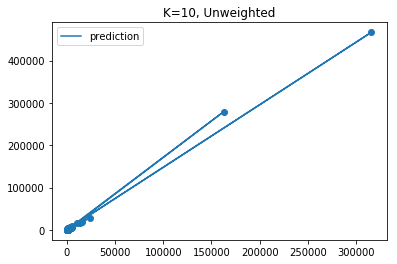

In [430]:
plt.scatter(X['LarcenyTheft_pop'], Y)
plt.plot(X['LarcenyTheft_pop'], Y, label='prediction')
plt.legend()
plt.title('K=10, Unweighted')
plt.show()

In [431]:
score = cross_val_score(regr, X, Y, cv=5)
print("Unweighted Accuracy: Score-mean %0.2f Score-std (+/- %0.2f)" % (score.mean()*100, score.std() * 2))

Unweighted Accuracy: Score-mean 98.07 Score-std (+/- 0.04)


In [432]:
def build_KNN_model(num_neighbors, X_val, Y_val, weight_type=None, print_detail=0):
    # Build our model.
        
    knn = neighbors.KNeighborsRegressor(n_neighbors=num_neighbors, weights=weight_type)
    knn.fit(X_val, Y_val)
    score = cross_val_score(knn, X_val, Y_val, cv=cv)

    if weight_type:
        label = 'Weighted'
    else:
        label = 'Unweighted'
        
    if print_detail:
        print("{:12} Accuracy: {:.0%}, (+/- {:.0%}) for neighbors={}, weights={},  ".format(
                                        label,
                                        score.mean(),
                                        score.std() * 2,
                                        num_neighbors, 
                                        weight_type))
    return score.mean().item(), weight_type, num_neighbors

In [433]:
print("KNN Regression:  Varying neighbor size, and weights between uniform, and distance.\n")
print_detail = 0
best_score = 0
best_score_array = []
counter = 1
for num_neighbors in range(2, 12):
    for weight in ['uniform', 'distance', None]:
        cv = 5
        score_mean, weight_type, num_neighbor = build_KNN_model (num_neighbors, X, Y, weight,print_detail=1)
        if score_mean > best_score:
            best_score_array = [score_mean, weight_type, num_neighbors]
            best_score = score_mean
#         print(" ")
print("Best KNN score was {:.0%}, and weight_type = {}, and neighbors={}".format(best_score_array[0],
                                                                             best_score_array[1],
                                                                             best_score_array[2]))

KNN Regression:  Varying neighbor size, and weights between uniform, and distance.

Weighted     Accuracy: 85%, (+/- 33%) for neighbors=2, weights=uniform,  
Weighted     Accuracy: 87%, (+/- 24%) for neighbors=2, weights=distance,  
Unweighted   Accuracy: 85%, (+/- 33%) for neighbors=2, weights=None,  
Weighted     Accuracy: 79%, (+/- 41%) for neighbors=3, weights=uniform,  
Weighted     Accuracy: 83%, (+/- 31%) for neighbors=3, weights=distance,  
Unweighted   Accuracy: 79%, (+/- 41%) for neighbors=3, weights=None,  
Weighted     Accuracy: 73%, (+/- 46%) for neighbors=4, weights=uniform,  
Weighted     Accuracy: 78%, (+/- 37%) for neighbors=4, weights=distance,  
Unweighted   Accuracy: 73%, (+/- 46%) for neighbors=4, weights=None,  
Weighted     Accuracy: 68%, (+/- 49%) for neighbors=5, weights=uniform,  
Weighted     Accuracy: 74%, (+/- 42%) for neighbors=5, weights=distance,  
Unweighted   Accuracy: 68%, (+/- 49%) for neighbors=5, weights=None,  
Weighted     Accuracy: 64%, (+/- 50%

Challenge Writeup:
I am favoring Ordinary Least Squares for the prediciton of this model. The interesting thing to note here is that if you run this model with the California dataset, the top KNN prediction is 94%, which surpasses the KNN prediction for New York, which is 87%.  How can a model vary the effectiveness based on the state under study?